In [1]:
import numpy as np
import os
DATA_PATH_TRAIN = '../../DATA/andysu/The_Street_View_House_Numbers_Dataset/train/'

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2


  0%|          | 0/33402 [00:00<?, ?it/s]

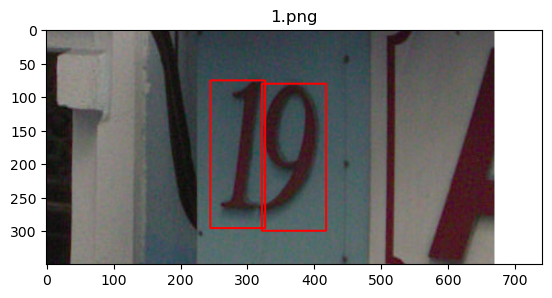

  0%|          | 0/33402 [00:00<?, ?it/s]


In [10]:
import h5py
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm 

PATH_MAT = '../../DATA/andysu/The_Street_View_House_Numbers_Dataset/train/digitStruct.mat'

def get_name(index, hdf5_data):
    name_ref = hdf5_data['/digitStruct/name'][index].item()
    return ''.join([chr(v[0]) for v in hdf5_data[name_ref]])


def get_bbox(index, hdf5_data):
    attrs = {}
    item_ref = hdf5_data['/digitStruct/bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = hdf5_data[item_ref][key]
        values = [hdf5_data[attr[i].item()][0][0].astype(int)
                  for i in range(len(attr))] if len(attr) > 1 else [attr[0][0]]
        attrs[key] = values
    return attrs

with h5py.File(PATH_MAT) as hdf5_data:
    for i in tqdm(range(33402)):
        img_name = get_name(i, hdf5_data)
        if not os.path.isfile(DATA_PATH_TRAIN+img_name):continue
        im = cv2.imread(DATA_PATH_TRAIN+img_name)
        h, w, c = im.shape
#         print(im.shape)
#         continue
#         fp = open(DATA_PATH_TRAIN+img_name.replace('.png','.txt'), 'w')
        arr = get_bbox(i, hdf5_data)
#         print(arr)
        arr_l = len(arr['label'])
        annotations = []
        for idx in range(arr_l):
            label = arr['label'][idx]
            if label==10:
                label = 0
            _l = arr['left'][idx]
            _t = arr['top'][idx]
            _w = arr['width'][idx]
            if (_l+_w)>w:
                _w = w-_l-1
            _h = arr['height'][idx]
            if (_t+_h)>h:
                _h = h-_t-1
            # print(w, h, _l, _t, _w , _h)
            x_center = (_l + _w/2)/w
            y_center = (_t + _h/2)/h
            bbox_width = _w/w
            bbox_height = _h/h
            start_point = (int(w * (x_center - (bbox_width/2))), int(h * (y_center- (bbox_height/2))))
            end_point = (int(w * (x_center + (bbox_width/2))), int(h * (y_center + (bbox_height/2))))
            im = cv2.rectangle(im, start_point, end_point, color, thickness)
            s = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(bbox_width)+' '+str(bbox_height)
            if idx!=(arr_l-1):
                s += '\n'
#             fp.write(s)
#         fp.close()
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(im)
        plt.title(img_name)
        plt.savefig("a.png")
        plt.show()
        break


In [23]:
import json
from tqdm import tqdm 
from detectron2.structures.boxes import BoxMode
def to_coco_format(start, end, name):
    data_result = []
    with h5py.File(PATH_MAT) as hdf5_data:
        for i in tqdm(range(start, end)):
            img_name = get_name(i, hdf5_data)
            im = cv2.imread(DATA_PATH_TRAIN+img_name)
            h, w, c = im.shape
            arr = get_bbox(i, hdf5_data)
            arr_l = len(arr['label'])
            annotations = []
            for idx in range(arr_l):
                label = arr['label'][idx]
                if label==10:
                    label = 0
                _l = arr['left'][idx]
                _t = arr['top'][idx]
                _w = arr['width'][idx]
                if (_l+_w)>w:
                    _w = w-_l-1
                _h = arr['height'][idx]
                if (_t+_h)>h:
                    _h = h-_t-1
                # print(w, h, _l, _t, _w , _h)
                x_center = (_l)/w
                y_center = (_t)/h
                bbox_width = _w/w
                bbox_height = _h/h
                
                start_point = (int(w * x_center), int(h * y_center))
                end_point = (int(w * (x_center + bbox_width)), int(h * (y_center + bbox_height)))
                im = cv2.rectangle(im, start_point, end_point, color, thickness)
                annotation = {}
                annotation["bbox"] = [int(w * x_center), int(h * y_center), int(w * bbox_width), int(h  * bbox_height)]
                annotation["bbox_mode"] = BoxMode.XYWH_ABS
                annotation["category_id"] = str(int(label))
                annotations.append(annotation)

            res = {}
            res["image_id"] = i
            res["file_name"] = img_name
            res["annotations"] = annotations
            res["height"] = h
            res["width"] = w
#             print(res)
#             plt.imshow(im)
#             plt.title(img_name)
#             plt.show()
            data_result.append(res)
    app_json = json.dumps(data_result)
    with open(DATA_PATH_TRAIN + name + ".json", 'w') as json_file:
        json.dump(data_result, json_file)
    with open(name + '.json', 'w') as json_file:
        json.dump(data_result, json_file)
to_coco_format(0, 31000, "train")
to_coco_format(31001, 33402, "val")

  1%|▏         | 434/31000 [00:02<03:08, 162.26it/s]


KeyboardInterrupt: 

In [11]:
# You may need to restart your runtime prior to this, to let your installation take effect
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [12]:
import json
from detectron2.structures import BoxMode
def get_board_dicts(imgdir):
    json_file = imgdir+"/coco_format.json" #Fetch the json file
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = imgdir+filename 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS #Setting the required Box Mode
            j["category_id"] = int(j["category_id"])
    return dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.clear()
#Registering the Dataset
classes = np.linspace(1, 10, 10)
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
print(classes)
for d in ["train", "val"]:
    DatasetCatalog.register("boardetect_" + d, lambda d=d: get_board_dicts("Digital_Detection_Dataset_COCO_Format/" + d))
    MetadataCatalog.get("boardetect_" + d).set(thing_classes=classes)
board_metadata = MetadataCatalog.get("boardetect_train")

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


../../DATA/andysu/The_Street_View_House_Numbers_Dataset/train/26.png


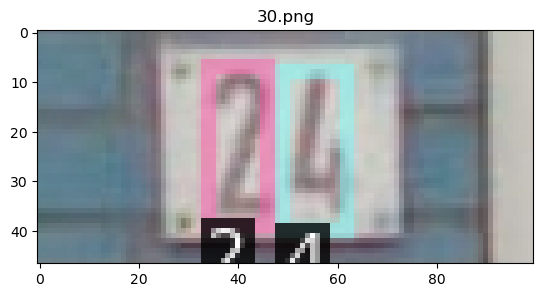

../../DATA/andysu/The_Street_View_House_Numbers_Dataset/train/4.png


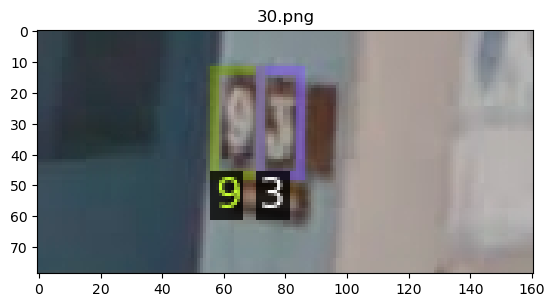

../../DATA/andysu/The_Street_View_House_Numbers_Dataset/train/17.png


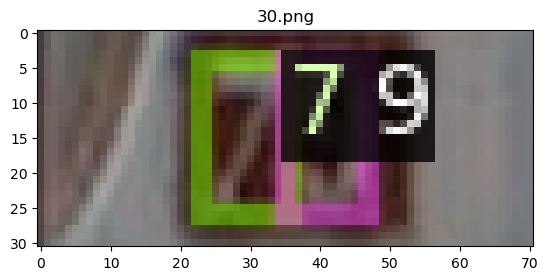

In [18]:
#Visualizing the Train Dataset
dataset_dicts = get_board_dicts(DATA_PATH_TRAIN)
#Randomly choosing 3 images from the Set
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata)
    vis = visualizer.draw_dataset_dict(d)
#     cv2_imshow(vis.get_image()[:, :, ::-1])
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.title(img_name)
    plt.show()

In [21]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5x')  # or yolov5m, yolov5l, yolov5x, custom

# Images
img = 'https://ultralytics.com/images/zidane.jpg'  # or file, Path, PIL, OpenCV, numpy, list

# Inference
results = model(img)

# Results
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

Using cache found in /home/me/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-11-15 torch 1.9.0+cu102 CUDA:0 (TITAN RTX, 24217MiB)



Fusing layers... 


Model Summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 720x1280 3 persons, 3 ties
Speed: 605.4ms pre-process, 19.1ms inference, 1.1ms NMS per image at shape (1, 3, 384, 640)


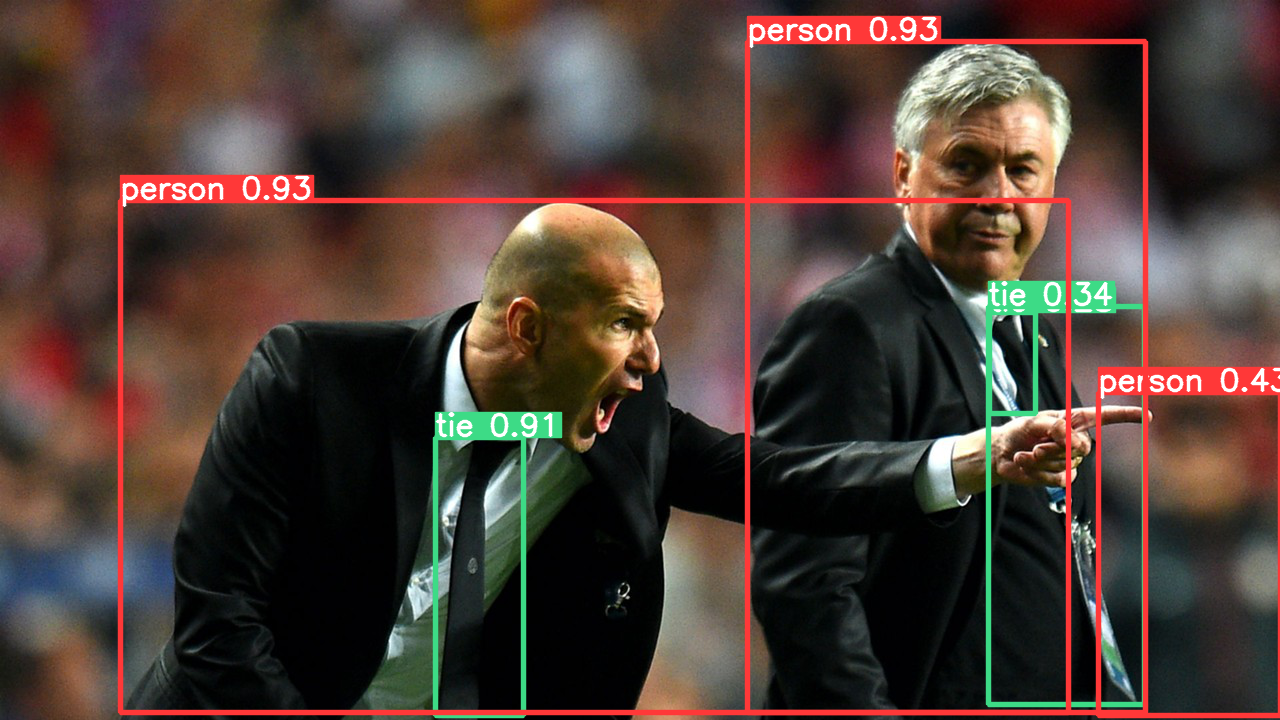

In [22]:
results.show()  # or .show(), .save(), .crop(), .pandas(), etc.